# M3. Actividad

Modela el sistema multiagente necesario para simular una intersección controlada por señales de semáforos inteligentes:

- Mientras no haya un vehículo cercano, el semáforo estará en luz amarilla. -Cuando un vehículo se acerque a la intersección, enviará un mensaje con el tiempo estimado de arribo.
-El semáforo dará luz verde al semáforo más cercano y establecerá un programa de luces a partir de ese punto para el resto de los vehículos.


# Agentes involucrados
Agentes reactivos simples, benevolentes

-Autos: Comunican distancia entre objetos y entre ellos

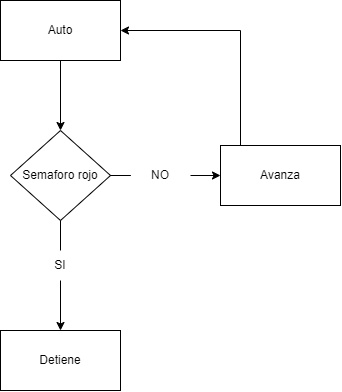

-Semaforos: Comunican su estado (luz actual) y tiempo de arribo

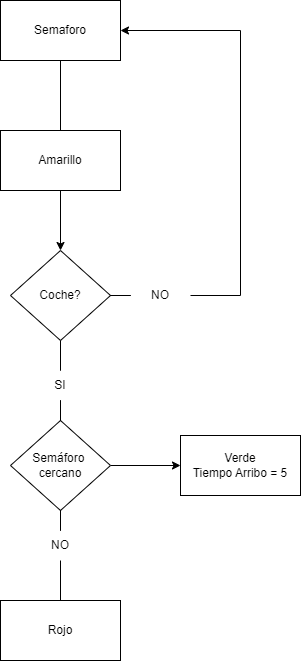

In [1]:
!pip install mesa matplotlib numpy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 66 kB 3.6 MB/s 


In [2]:
from mesa import Agent, Model
from mesa.space import MultiGrid 
from mesa.space import SingleGrid 
from mesa.time import SimultaneousActivation 
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap, BoundaryNorm
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd
import random

import time 
import datetime

In [3]:
cmap = ListedColormap([(1, 1, 1), (0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)])

#0 blanco
#1 azul
#4 verde
#5 amarillo
#6 rojo

bounds = [0,1,4,5,6,7]

norm = BoundaryNorm(bounds, cmap.N)

contDown = 0
contRight = 0

In [20]:
class Terreno(Agent): 
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.live = 1
    
class Semaforo(Agent):
  def __init__(self, unique_id, model, direccion=None):
    super().__init__(unique_id, model)
    self.color = "red"
    self.direccion = None

    if self.unique_id == 0:
      self.direccion = "right"
    elif self.unique_id == 1:
      self.direccion = "left"
    elif self.unique_id == 2:
      self.direccion = "up"
    else:
      self.direccion = "down"
    
  def step(self):
    pass

class Carro(Agent):
  DIRECTIONS = ['right','down','left','up']

  def __init__(self, unique_id, model, direction=None):
    super().__init__(unique_id, model)
    self.pos = (0,0)
    self._direction = None
    self.next_pos = None
    self.color = "blue"

    self.direction = self.random.choice(self.DIRECTIONS) if not direction else direction

  @property
  def direction(self):
    return self._direction

  @direction.setter
  def direction(self, direction):
    self._direction = direction
    if self._direction == 'up':
      self.dx, self.dy = 0, -1
    elif self._direction == 'down':
      self.dx, self.dy = 0, 1
    if self._direction == 'right':
      self.dx, self.dy = -1, 0
    elif self._direction == 'left':
      self.dx, self.dy = 1, 0

  def step(self):
    next_pos = (self.pos[0] + self.dx, self.pos[1] + self.dy)

    if self.model.grid.out_of_bounds(next_pos):
      self.next_pos = self.model.grid.torus_adj(next_pos)
    else:
      self.next_pos = next_pos

  def advance(self):
      x = True
      neighbors = self.model.grid.get_neighbors(self.pos, moore=False, include_center=False)

      for n in neighbors:
        if self.direction == "up" or self.direction == "down":
          if isinstance(n, Semaforo):
            if n.unique_id == 0 or n.unique_id == 1:
              if n.color == "red" or n.color == "yellow":
                x = False

        elif self.direction == "right" or self.direction == "left":
          if isinstance(n, Semaforo):
            if n.unique_id == 2 or n.unique_id == 3:
              if n.color == "red" or n.color == "yellow":
                x = False

      if self.model.grid.is_cell_empty(self.next_pos) and x:
        self.model.grid.move_agent(self, self.next_pos)
        self.pos = self.next_pos

class Interseccion(Model):
  def __init__(self,width, height):
    self.temp = 0
    self.inicialTime = 5
    self.num_agents = width * height

    self.grid = SingleGrid(width, height, True)
    self.schedule = SimultaneousActivation(self)

    cont = 0
    self.sema = list()

    for x, y in [((width//2 - 2), (height//2 + 1)), ((width//2 + 1), (height//2 - 2)), ((width//2 + 1), (height//2 + 1)), ((width//2 - 2), (height//2 - 2))]:
      s = Semaforo(cont, self)
      if cont == 0:
        s.color = "green"
      self.grid.place_agent(s, (x,y))
      cont += 1
      self.sema.append(s)

    seleccion = self.random.choice(Carro.DIRECTIONS)
    carro = Carro(cont, self, direction=seleccion)
    self.schedule.add(carro)

    cont += 1

    if seleccion == "right":
        pos = (0, height//2)
    elif seleccion == "down":
        pos = (width//2, 0)
    elif seleccion == "left":
        pos = (width-1, height//2-1)
    elif seleccion == "up":
        pos = (width//2-1, height-1)
    
    self.grid.place_agent(carro, pos)

    for content, x, y in self.grid.coord_iter():
      if (not content) and (x not in [width//2-1, width//2] and (y not in [height//2-1, height//2])):
        t = Terreno(f"t{cont}", self)
        self.grid.place_agent(t, (x,y))
        self.schedule.add(t)
        cont += 1

    self.datacollector = DataCollector(
        model_reporters={"Grid": self.get_grid, 
                         "JSON_step": self.read_agents})

  def place_car(self, cont, size, contCar):
    global contDown
    global contRight
    seleccion = self.random.choice(Carro.DIRECTIONS)
    carro = Carro(cont, self, direction=seleccion)
    self.schedule.add(carro)

    if seleccion == "right":
        pos = (0, size//2)
    elif seleccion == "down":
        pos =(size//2, 0)
    elif seleccion == "left":
        pos = (size-1 ,size//2-1)
    elif seleccion == "up":
        pos= (size//2-1, size-1)

    if seleccion == "right":
        if self.grid.is_cell_empty(pos):
            self.grid.place_agent(carro, pos)
    if seleccion == "down":
        if self.grid.is_cell_empty(pos):
            self.grid.place_agent(carro, pos)
    if seleccion == "left":
        if self.grid.is_cell_empty(pos):
            self.grid.place_agent(carro, pos)
    if seleccion == "up":
        if self.grid.is_cell_empty(pos):
            self.grid.place_agent(carro, pos)
  
  def step(self, cont, size, contCar):
    self.datacollector.collect(self)
    self.schedule.step()
    if cont%3 == 0 and cont < 260:
        self.place_car(cont, size, contCar)
    
    if self.temp < self.inicialTime:
      self.temp += 1
    else:
      for i, sem in enumerate(self.sema):
        if sem.color == "green":
          self.sema[i].color = "red"
          self.temp = 0
          if i < 3:
            nextSem = i + 1
          else:
            nextSem = 0
          self.sema[nextSem].color = "green"
          break  
  
  def get_grid(self):

    grid = np.zeros((self.grid.width, self.grid.height))

    for cell in self.grid.coord_iter():
      cell_content, x, y = cell
      if isinstance(cell_content, Carro):
        if cell_content.color == "blue":
            grid[x][y] = 1
      elif isinstance(cell_content, Semaforo):
        if cell_content.color == "yellow":
            grid[x][y] = 5
        elif cell_content.color == "green":
            grid[x][y] = 4
        elif cell_content.color == "red":
            grid[x][y] = 6
      else:
        grid[x][y] = 0
      
    return grid

  def read_agents(self):
    agents_list = []
    for cell in self.grid.coord_iter():
      agent, x, y = cell

      if isinstance(agent, Carro):
          agent_dict = {'id': agent.unique_id, 'kind': 'carro', 'positionX': agent.pos[0], 'positionY': 0, 'posiitonZ': agent.pos[1], 'color': agent.color}
      elif isinstance(agent, Semaforo):        
          agent_dict = {'id': agent.unique_id, 'kind': 'semforo', 'positionx': agent.pos[0], 'positionY': 0, 'positionZ': agent.pos[1], 'color': agent.color}
      else:
        agent_dict = {}

      if len(agent_dict) != 0:
          agents_list.append(agent_dict)

    return agents_list                                                                     

In [21]:
GRID_SIZE = 10

CAR_CONT = 1

NUM_GENERATIONS = 20

model = Interseccion(GRID_SIZE, GRID_SIZE)

contCarros = 200

for i in range(NUM_GENERATIONS):
    model.step(contCarros, GRID_SIZE, CAR_CONT)
    contCarros += 1

In [22]:
all_grid = model.datacollector.get_model_vars_dataframe()

In [23]:
%%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap,norm)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [ ]:
anim